# Minimal

We demonstrate the gridding of fields with `cygrid` with a minimal example, using infrared data from the Planck mission. While the image here is only two-dimensional, we note that `cygrid` was designed for spectroscopic HI data, so the handling of the spectral axis is well-supported.

We start by adjusting the notebook settings.

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

We attempt to limit our dependencies as much as possible, but [`astropy`](https://astropy.readthedocs.org/en/stable/) and [`wcsaxes`](http://wcsaxes.readthedocs.org/en/latest/) needs to be available on your machine if you want to re-run the calculations. We can highly recommend [`anaconda`](https://www.continuum.io/downloads) as a scientific `python` platform.

In [5]:
import numpy as np
import matplotlib.pyplot as pl

from astropy.io import fits
from astropy.coordinates import SkyCoord
# We'll be loading some data from skyview, hence the longer timeout
from astropy.utils.data import conf
conf.remote_timeout = 60.
from wcsaxes import WCS

import cygrid

Let's define some plotting `kwargs` for the images.

In [9]:
imkw = dict(
    cmap='YlGnBu_r',
    origin='lower',
    interpolation='None')

For our first demonstration, we illustrate how to grid from a large fits-file onto a user-defined header.
First, we need to obtain our input image. We use `skyview` to get an image of Planck 545 GHz data.

In [10]:
input_data, input_header = fits.getdata(
    'http://skyview.gsfc.nasa.gov/current/cgi/runquery.pl?Survey=Planck+545&position=200.,20.&pixels=500&Return=FITS',
    header=True)

Here's an image of what this field looks like. `wcsaxes` is a simple tool to combine the `matplotlib` with information from the world-coordinate system (WCS).

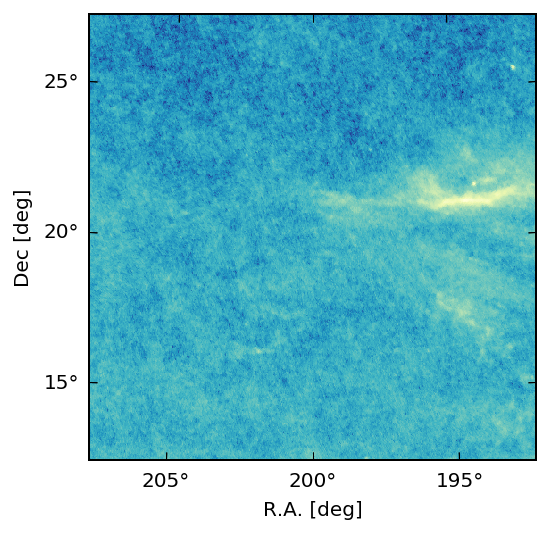

In [11]:
input_wcs = WCS(input_header)
fig = pl.figure()
ax = fig.add_subplot(111, projection=input_wcs)
lon, lat = ax.coords
ax.imshow(np.log10(input_data), **imkw)
lon.set_axislabel('R.A. [deg]')
lat.set_axislabel('Dec [deg]')

We manually create the `header` onto which we will grid the data. You need to make sure that all the celestial information are available and that the header is three-dimensional, even if it involes creating an artifical (pseudo-)axis.

In [12]:
target_header = fits.Header()

pixsize = 1.5/60.

target_header['SIMPLE'] = 'T'
target_header['BITPIX'] = -32
target_header['NAXIS'] = 3

target_header['NAXIS1'] = 350
target_header['NAXIS2'] = 150
target_header['NAXIS3'] = 1

target_header['CDELT1'] = -pixsize
target_header['CDELT2'] = pixsize
target_header['CDELT3'] = 1.

target_header['CRPIX1'] = 0
target_header['CRPIX2'] = 0
target_header['CRPIX3'] = 0

target_header['CRVAL1'] = 202.
target_header['CRVAL2'] = 19.
target_header['CRVAL3'] = 0.

target_header['CTYPE1'] = 'RA---SFL'
target_header['CTYPE2'] = 'DEC--SFL'
target_header['CTYPE3'] = 'VRAD'
target_header['BUNIT'] = 'MJY.SR**-1'

target_wcs = WCS(target_header)

We start the gridding by initating the gridder with the `target_header`. Prior to this, we need to add a third axis to this header because `cygrid` was designed for three-dimensional data.

In [13]:
gridder = cygrid.WcsGrid(target_header)

To grid one image onto another, we need the coordinates for each pixel in the input image. To obtain these, we start by getting pixel coordinates with `np.meshgrid`.

In [14]:
input_lon_pix, input_lat_pix = np.meshgrid(np.arange(input_header['NAXIS1']), np.arange(input_header['NAXIS2']))

Next, we convert these from pixel- to world-coordinates, using the `wcs` features from `astropy`.

In [15]:
input_lon_world, input_lat_world = input_wcs.all_pix2world(input_lon_pix, input_lat_pix, 0)

The gridding kernel is of key importance for the entire gridding process. `cygrid` allows you to specify the shape of the kernel (e.g. elliptical Gaussian or tapered sinc) and its size.

In our example, we use a symmetrical Gaussian (i.e. the major and minor axis of the kernel are identical). In that case, we need to furthermore specify `kernelsize_sigma`, the `sphere_radius` up to which the kernel will be computed, and the maximum acceptable healpix resolution for which we recommend `kernelsize_sigma/2`.

We refer to section 3.5 of the paper ('a minimal example') for a short discussion of the kernel parameters.

In [21]:
kernelsize_fwhm = 2.5/60.
kernelsize_sigma = kernelsize_fwhm / 2.355 # https://en.wikipedia.org/wiki/Full_width_at_half_maximum
sphere_radius = 3. * kernelsize_sigma

gridder.set_kernel(
    'gauss1d',
    (kernelsize_sigma,),
    sphere_radius,
    kernelsize_sigma / 2.
    )

After the kernel has been set, we perform the actual gridding by calling `grid()` with the flattened coordinates and the data. Note that we need to add an artifical third axis to the `input_data`.

In [17]:
gridder.grid(
    input_lon_world.flatten(),
    input_lat_world.flatten(),
    input_data.reshape(-1, 1))

To get the gridded data, we simply call `get_datacube()`. We get rid of the degenerate third axis by using `squeeze()`.

In [18]:
datacube = gridder.get_datacube().squeeze()

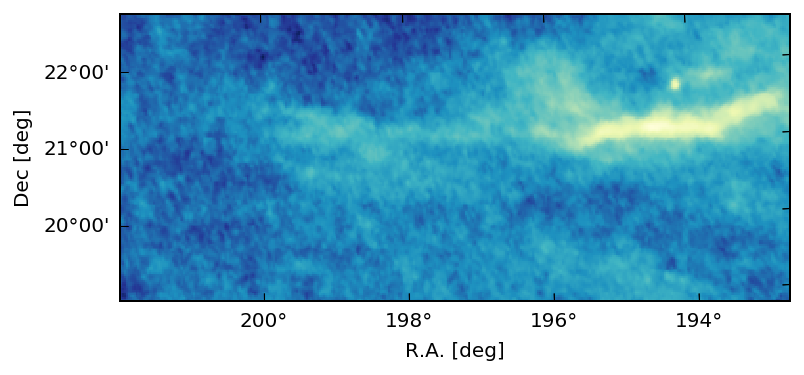

In [19]:
fig = pl.figure()
ax = fig.add_subplot(111, projection=target_wcs.celestial)
lon, lat = ax.coords
ax.imshow(np.log10(datacube), **imkw)
lon.set_axislabel('R.A. [deg]')
lat.set_axislabel('Dec [deg]')

Finally, we can write the fits-image to disk:

In [24]:
fits.writeto('planck_regridded.fits', datacube, target_wcs.celestial.to_header(), clobber=True)